# Optimizing Transformers for Production with PyTorch and Hugging Face

Transformers have revolutionized the field of natural language processing (NLP) with their outstanding performance on a variety of tasks. However, deploying these models into production can be challenging due to their size and computational requirements. This tutorial aims to provide practical strategies for optimizing transformer models using PyTorch and the Hugging Face Transformers library, ensuring they are more efficient and cost-effective for production environments.

## Setting Up the Environment
First, let's set up our environment. Ensure you're running this notebook in Google Colab or a similar environment where you can install packages.

In [1]:
!pip install -q torch torchvision torchaudio
!pip install -q transformers

After installation, it's crucial to verify the versions of the packages to ensure reproducibility:



In [2]:
import torch
import transformers

print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")

PyTorch version: 2.1.0+cu121
Transformers version: 4.37.2


## Understanding Transformer Model Optimization

Before diving into code, it's important to understand what makes transformers difficult to deploy and how we can mitigate these issues.

## Challenges:

* Size: Transformers, especially models like BERT and GPT, have millions of
parameters, making them heavy for deployment.
* Speed: The inference time can be slow, which is not ideal for applications requiring real-time responses.
* Cost: Computational requirements translate into higher costs for infrastructure.

## Solutions:

1. Quantization: Converts model weights from floating point to integers to reduce model size and improve inference speed.
2. Pruning: Removes unnecessary weights or neurons from the model to reduce size and computation.
3. Distillation: Trains a smaller model (student) to mimic a larger model (teacher) to retain performance while being more efficient.
4. Dynamic Quantization with PyTorch: PyTorch offers dynamic quantization, which quantizes weights dynamically during model inference, offering a good balance between performance and speed.

## Implementing Model Optimization
Now, let's walk through the steps of optimizing a transformer model for production.

### Step 1: Load a Pre-Trained Model
We'll start by loading a pre-trained model from Hugging Face's Transformers library. For this tutorial, we'll use the bert-base-uncased model as an example.

In [3]:
from transformers import BertModel, BertTokenizer

model_name = 'bert-base-uncased'
model = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Step 2: Quantization
Quantization reduces the model size and speeds up inference times. PyTorch simplifies this process with its dynamic quantization feature.

In [4]:
from torch.quantization import quantize_dynamic

# Specify the parts of the model we wish to quantize. In this case, the linear layers.
model_quantized = quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)

### Visualization
To understand the impact of quantization, let's compare the model sizes before and after quantization.

In [5]:
import os
import tempfile

def model_size(model):
    with tempfile.NamedTemporaryFile(prefix="model", suffix=".pt", delete=False) as tmp:
        torch.save(model.state_dict(), tmp.name)
        size = os.path.getsize(tmp.name) / 1e6 # Convert to MB
    os.unlink(tmp.name) # Clean up
    return size

original_size = model_size(model)
quantized_size = model_size(model_quantized)
print(f"Original model size: {original_size} MB")
print(f"Quantized model size: {quantized_size} MB")


Original model size: 438.006182 MB
Quantized model size: 181.489582 MB


### Step 3: Model Pruning
Pruning is another technique to reduce model size and computational load. Here's how you can apply pruning to a transformer model.

In [7]:
from transformers import BertModel, BertTokenizer
import torch.nn.utils.prune as prune

# Load the pre-trained model
model_name = 'bert-base-uncased'
model = BertModel.from_pretrained(model_name)

# Define the layers and parameters you want to prune
parameters_to_prune = [
    (model.encoder.layer[0].attention.self.query, 'weight'),
    (model.encoder.layer[0].attention.self.key, 'weight'),
    (model.encoder.layer[0].attention.self.value, 'weight'),
]

# Apply pruning to the specified layers by 20%
for module, param in parameters_to_prune:
    prune.l1_unstructured(module, name=param, amount=0.2)
    prune.remove(module, param)  # Make pruning permanent


### Step 4: Knowledge Distillation
Knowledge distillation requires training, so we'll outline the process rather than execute it, due to its complexity and time requirements.

In [8]:
# Pseudo code for knowledge distillation
# 1. Choose your teacher and student models. The student should be smaller.
# 2. Train the student model to mimic the teacher's outputs on a given dataset.
# 3. Evaluate the student's performance and adjust the training process as necessary.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 0.6970, Validation Accuracy: 59.38%
Epoch 2, Loss: 0.6936, Validation Accuracy: 59.38%
Epoch 3, Loss: 0.6940, Validation Accuracy: 46.88%
Epoch 4, Loss: 0.6928, Validation Accuracy: 59.38%
Epoch 5, Loss: 0.6929, Validation Accuracy: 59.38%
Epoch 6, Loss: 0.6928, Validation Accuracy: 59.38%
Epoch 7, Loss: 0.6927, Validation Accuracy: 59.38%
Epoch 8, Loss: 0.6937, Validation Accuracy: 40.62%
Epoch 9, Loss: 0.6937, Validation Accuracy: 59.38%
Epoch 10, Loss: 0.6936, Validation Accuracy: 59.38%


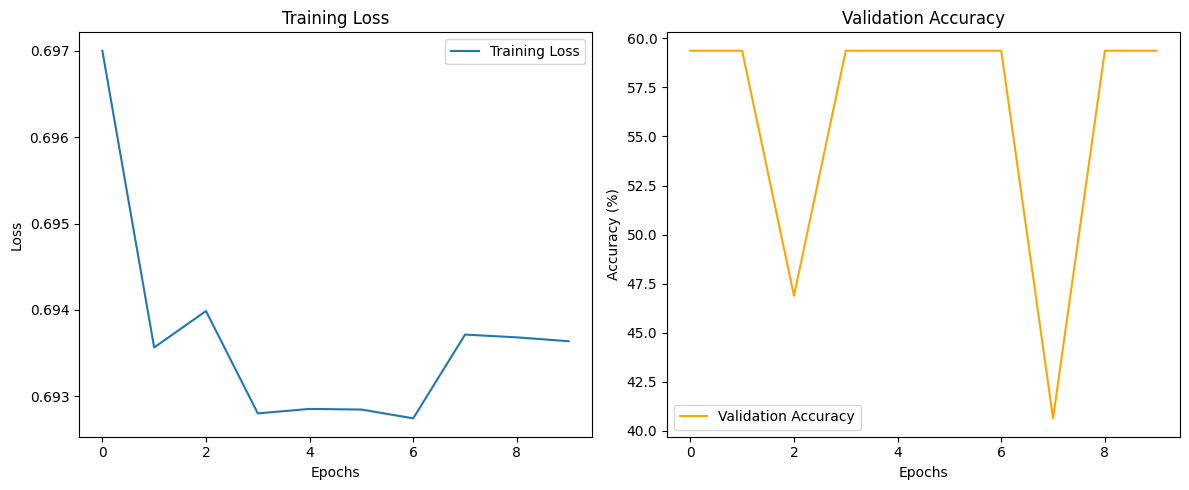

In [12]:
import torch
from torch import nn, optim
from transformers import BertForSequenceClassification, BertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, random_split
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# Dummy data: 100 samples, sequence length of 30
num_samples = 100
seq_length = 30
dummy_data = torch.randint(0, 2000, (num_samples, seq_length))  # Random token IDs
dummy_labels = torch.randint(0, 2, (num_samples,))  # Binary labels

# Split data into training and validation
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size
train_dataset, val_dataset = random_split(TensorDataset(dummy_data, dummy_labels), [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Load Teacher and Student Models
teacher_model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
student_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

# Ensure both models are in training mode
teacher_model.train()
student_model.train()

# Train Student Model via Knowledge Distillation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model.to(device)
student_model.to(device)

optimizer = AdamW(student_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Initialize lists to store loss and accuracy for each epoch
epoch_losses = []
epoch_accuracies = []

epochs = 10
for epoch in range(epochs):
    student_model.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Get teacher predictions
        with torch.no_grad():
            teacher_outputs = teacher_model(inputs)[0]

        # Train student
        student_outputs = student_model(inputs)[0]
        loss = criterion(student_outputs, teacher_outputs.softmax(dim=-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Average loss for this epoch
    epoch_loss /= len(train_loader)
    epoch_losses.append(epoch_loss)

    # Validation for this epoch
    student_model.eval()
    total_eval_accuracy = 0
    for batch in val_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():
            outputs = student_model(inputs)[0]

        preds = torch.argmax(outputs, dim=1).flatten()
        accuracy = (preds == labels).cpu().numpy().mean() * 100
        total_eval_accuracy += accuracy

    avg_val_accuracy = total_eval_accuracy / len(val_loader)
    epoch_accuracies.append(avg_val_accuracy)

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.2f}%")

# Plotting training loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epoch_accuracies, label='Validation Accuracy', color='orange')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
# Validation
student_model.eval()
total_eval_accuracy = 0

for batch in val_loader:
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.no_grad():
        outputs = student_model(inputs)[0]

    preds = torch.argmax(outputs, dim=1).flatten()
    accuracy = (preds == labels).cpu().numpy().mean() * 100
    total_eval_accuracy += accuracy

avg_val_accuracy = total_eval_accuracy / len(val_loader)
print(f"Validation Accuracy: {avg_val_accuracy:.2f}%")

Validation Accuracy: 59.38%


## Final Thoughts and Further Steps
Optimizing transformers for production involves trade-offs between model size, speed, and accuracy. Techniques like quantization, pruning, and distillation can significantly improve efficiency, but it's crucial to evaluate the optimized model to ensure it meets your application's requirements.